> 시작하기 전에

아래 참고자료를 활용하였습니다.

- 2024-1 DSC공유대학 모빌리티 AI/SW 과정 '딥러닝'
- 2024-2 순천향대학교 컴퓨터소프트웨어공학과 '머신러닝'
- [싸이킷런 데이터 전처리 스케일 조정(스케일러)](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=demian7607&logNo=222009975984)
- [Google Colab 데이터 업로드 및 활용](https://stackoverflow.com/questions/52761829/how-do-i-upload-my-own-data-for-tensor-flow-using-google-colab)
- [CSV 파일 가져오는 법(사용하지 않음)](https://ericabae.medium.com/tensorflow-2-0-csv-%ED%8C%8C%EC%9D%BC-%ED%98%95%EC%8B%9D-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EA%B0%80%EC%A0%B8%EC%98%A4%EA%B8%B0-eddaa88d3112)
- [레이블 없을 때의 `train_test_split`](https://hye0archive.tistory.com/8)
- [Label Encoding](https://velog.io/@hhhs101/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%9D%B8%EC%BD%94%EB%94%A9-Label-Encoding-One-hot-Encodingdummies)
- [마지막 열 제외하기](https://velog.io/@hhhs101/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%9D%B8%EC%BD%94%EB%94%A9-Label-Encoding-One-hot-Encodingdummies)
- [마지막 열만 선택하기](https://stackoverflow.com/questions/40144769/how-to-select-the-last-column-of-dataframe)

## 데이터 업로드

Google Colab에서는 런타임 종료 시 파일이 삭제되므로, 매번 업로드하도록 구성하였다.

In [2]:
from google.colab import files

print("car_evaluation.csv 파일을 업로드해주세요.")
uploaded = files.upload()

for fn in uploaded.keys():
  print("Uploaded File '{name}'".format(name = fn))

car_evaluation.csv 파일을 업로드해주세요.


Saving car_evaluation.csv to car_evaluation.csv
Uploaded File 'car_evaluation.csv'


## 업로드한 데이터 확인

In [3]:
!head car_evaluation.csv

vhigh,vhigh,2,2,small,low,unacc
vhigh,vhigh,2,2,small,med,unacc
vhigh,vhigh,2,2,small,high,unacc
vhigh,vhigh,2,2,med,low,unacc
vhigh,vhigh,2,2,med,med,unacc
vhigh,vhigh,2,2,med,high,unacc
vhigh,vhigh,2,2,big,low,unacc
vhigh,vhigh,2,2,big,med,unacc
vhigh,vhigh,2,2,big,high,unacc
vhigh,vhigh,2,4,small,low,unacc


## 데이터 전처리

`pandas` 라이브러리를 이용하여 CSV 파일을 읽고, LabelEncoder로 범주형 데이터를 숫자 형태의 데이터로 변환한다.

- OneHotEncoder를 사용하려고 하였으나, 데이터 차원이 호환되지 않아 변경하였다.
- LabelEncoding은 선형 회귀 등에선 예측 성능이 떨어는 경우가 있어 적용하지 않으나, 이번 예시와 같이 트리 계열의 알고리즘 이용에는 문제가 없다.
- LabelEncoding을 여러 행에 적용해야 하므로 for문을 사용하되, DataFrame의 Column만 추출하는 메서드를 활용한다.
- 데이터에 대한 설명이 전혀 없어 어떤 의미인지 알기 어려우나, `unacc`는 정황상 unaccepted, `vgood`은 very good을 의미하는 것으로 보여 마지막 열이 결과인 것으로 추정하여 데이터를 준비하였다.

In [9]:
import io
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 파일 읽기 및 Label Encoder로 데이터 변환
data = pd.read_csv(io.StringIO(uploaded['car_evaluation.csv'].decode('utf-8')))

for i in data.columns:
  data[i] = LabelEncoder().fit_transform(data[i])


# 데이터 준비. 마지막 열을 레이블로 지정
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size=0.2, random_state=42)

## 모델 학습



### 의사결정트리(의사결정나무)

> Decision Tree

데이터를 트리 구조로 나눠 예측 구조를 만드는 분류 기법의 알고리즘으로, 각 노드에서 특정 조건으로 데이터를 분할하고 최종 노드에서 결과를 예측한다.

각 트리는 정해진 기준에 따라 가지치기한다. 따라서, 한쪽 가지에 비슷한 클래스가 모여있으면 좋은 모델로 평가한다. 트리 구조로 표현이 가능하므로, 단순하면서도 직관적이고 해석이 쉽다는 장점을 갖는다.

다만, 과적합 발생 가능성이 다소 높다.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 모델 사용
dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train, y_train)
dt_res = dt.predict(x_test)

# 모델 정확도 측정
dt_score = accuracy_score(y_test, dt_res)

### Random Forest

- 여러 개의 결정 트리를 결합한 앙상블 학습 방법.
- 단일 결정 트리에 비해 과적합이 덜하고 분산, 편향을 줄여 일반화 성능을 높인다.
- 앙상블 방식 중 병렬 학습 결과를 다수결 혹은 평균으로 결정하는 배깅(Bagging) 방식을 사용한다.

> 앙상블이란 여러 방식의 모델을 혼합하여 더 좋은 결과를 도모하는 방식으로, 서로 다른 알고리즘으로 예측한 결과를 다수결이나 평균으로 결정하는 Voting, 같은 알고리즘을 사용하면서 앞선 결과로 다음 학습기가 순차 학습해 오차를 줄여나가는 부스팅(Boosting) 방식 등이 있다.

#### 작동 원리

- 데이터 샘플링 - 훈련 데이터의 랜덤 서브셋 생성(bootstrap sampling)
- 랜덤성 도입 - 각 트리가 서로 다른 특성 집합 사용
- 다수결 - 모든 트리의 예측 결과를 결합해 최종 예측 (앙상블의 특성)

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
rf_res = rf.predict(x_test)

rf_score = accuracy_score(y_test, rf_res)

## 결과 시각화

- 정확도 비교
- Confusion Matrix
- 특성 중요도 계산

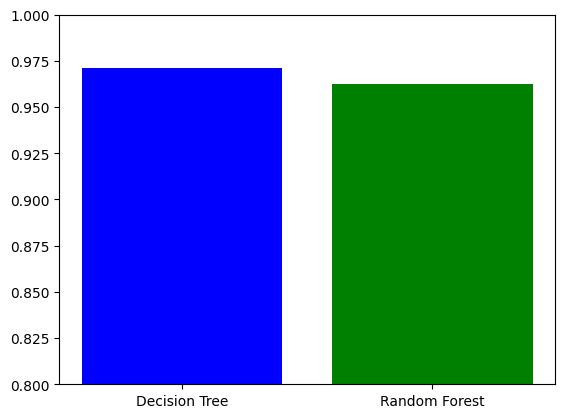

In [16]:
import matplotlib.pyplot as plt

plt.bar(np.arange(2), [dt_score, rf_score], color=['b', 'g'])
plt.ylim(0.8, 1.0)
plt.xticks(np.arange(2), ['Decision Tree', 'Random Forest'])
plt.show()

이를 통해 Random Forest 방식보다 단일 Decision Tree 방식이 약간 더 높은 정확도를 보인 것을 확인할 수 있다. 그러나, Random Forest가 본래 여러 트리를 모아 안정성을 높이는 기법임을 고려할 때 이는 의사결정트리가 더 훌륭한 방식이라서, 라기보다는 train data에 더 가깝게 적합되었기 때문으로 보인다.